# 0. Imports 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from os import listdir
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import svm, tree
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.neural_network import MLPClassifier

from boruta import BorutaPy
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

/home/mahelvson/anaconda3/envs/foot/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## 0.1 Helper Functions 

In [300]:
def check_last_match(df):
    """
    This function checks if a team won the last match and how many gols each team scored
    """
    seasons = df['data'].dt.year.unique()
    df_result = pd.DataFrame()
    for season in seasons:
        df_season = df[df['data'].dt.year == season]        
        for round_n in range(1, max(df_season.rodada) + 1):
            df_round_n = df_season[df_season['rodada'] == round_n]
            for idx in df_round_n.ID.values:                
                home = df.loc[idx, 'mandante']
                away = df.loc[idx, 'visitante'] 
                if round_n > 1:
                    # win ?
                    if ((df_season['rodada'] == round_n -1) & (df_season['vencedor'] == home)).any():
                        df_season.loc[idx, 'mandante_venceu_ultima'] = 1.0
                    else:
                        df_season.loc[idx, 'mandante_venceu_ultima'] = 0.
                        
                    if ((df_season['rodada'] == round_n -1) & (df_season['vencedor'] == away)).any():
                        df_season.loc[idx, 'visitante_venceu_ultima'] = 1.0                    
                    else:                     
                        df_season.loc[idx, 'visitante_venceu_ultima'] = 0.
                        
                    # n. of goals
                    if ((df_season['rodada'] == round_n-1) & (df_season['mandante'] == home)).any():
                        df_season.loc[idx, 'n_gols_mandante_ultima'] = df_season[((df_season['rodada'] == round_n-1) & (df_season['mandante'] == home))]['mandante_placar'].values[0]
                        
                    elif ((df_season['rodada'] == round_n-1) & (df_season['visitante'] == home)).any():
                        df_season.loc[idx, 'n_gols_mandante_ultima'] = df_season[((df_season['rodada'] == round_n-1) & (df_season['visitante'] == home))]['visitante_placar'].values[0]
                    
                    if ((df_season['rodada'] == round_n-1) & (df_season['mandante'] == away)).any():
                        df_season.loc[idx, 'n_gols_visitante_ultima'] = df_season[((df_season['rodada'] == round_n-1) & (df_season['mandante'] == away))]['mandante_placar'].values[0]
                        
                    elif ((df_season['rodada'] == round_n-1) & (df_season['visitante'] == away)).any():
                        df_season.loc[idx, 'n_gols_visitante_ultima'] = df_season[((df_season['rodada'] == round_n-1) & (df_season['visitante'] == away))]['visitante_placar'].values[0]
               
                else:                 
                    df_season['mandante_venceu_ultima'] = 0
                    df_season['visitante_venceu_ultima'] = 0
                    df_season['n_gols_mandante_ultima'] = 0
                    df_season['n_gols_visitante_ultima'] = 0
                    
        df_result = pd.concat([df_result, df_season], axis = 0)
    return df_result

# 1. Loading Data 

In [2]:
data_path = '../datasets/'
files = listdir(data_path)

In [3]:
files

['campeonato-brasileiro-cartoes.csv',
 'campeonato-brasileiro-full.csv',
 'campeonato-brasileiro-estatisticas-full.csv',
 'campeonato-brasileiro-gols.csv',
 'Legenda.txt']

In [4]:
cards = files[0]
full = files[1]
stats = files[2]
goals = files[3]

## 1.1 Cards

In [5]:
df_cards = pd.read_csv(data_path + cards)
df_cards.head()

,partida_id,rodada,clube,cartao,atleta,num_camisa,posicao,minuto
0,4607,1,Figueirense,Amarelo,Thiago Heleno,4.0,Zagueiro,44
1,4607,1,Figueirense,Amarelo,Paulo Roberto da Silva,28.0,NaN,66
2,4608,1,Internacional,Amarelo,Juan Silveira dos Santos,4.0,Zagueiro,20
3,4608,1,Vitoria,Amarelo,Vinícius Santos Silva,NaN,NaN,82
4,4608,1,Internacional,Amarelo,Andrés D'Alessandro,10.0,Meio-campo,72


In [6]:
df_cards.isna().sum() / df_cards.shape[0]

partida_id    0.000000
rodada        0.000000
clube         0.000000
cartao        0.000000
atleta        0.000406
num_camisa    0.026138
posicao       0.081121
minuto        0.000000
dtype: float64

In [7]:
df_cards.shape

(14768, 8)

In [8]:
df_cards.dtypes

partida_id      int64
rodada          int64
clube          object
cartao         object
atleta         object
num_camisa    float64
posicao        object
minuto         object
dtype: object

Quantidade de NaN é no máximo 8% em relação ao total da registros.

## 1.2 Full

In [61]:
df_full = pd.read_csv(data_path + full)
df_full.head()

,ID,rodada,data,hora,dia,mandante,visitante,formacao_mandante,formacao_visitante,tecnico_mandante,tecnico_visitante,vencedor,arena,mandante_placar,visitante_placar,mandante_estado,visitante_estado,estado_vencedor
0,1,1,2003-03-29,16:00,Sabado,Guarani,Vasco,NaN,NaN,NaN,NaN,Guarani,brinco de ouro,4,2,SP,RJ,SP
1,2,1,2003-03-29,16:00,Sabado,Athletico-PR,Gremio,NaN,NaN,NaN,NaN,Athletico-PR,arena da baixada,2,0,PR,RS,PR
2,3,1,2003-03-30,16:00,Domingo,Flamengo,Coritiba,NaN,NaN,NaN,NaN,-,maracana,1,1,RJ,PR,-
3,4,1,2003-03-30,16:00,Domingo,Goias,Paysandu,NaN,NaN,NaN,NaN,-,serra dourada,2,2,GO,PA,-
4,5,1,2003-03-30,16:00,Domingo,Internacional,Ponte Preta,NaN,NaN,NaN,NaN,-,beira rio,1,1,RS,SP,-


In [194]:
df_full = df_full[df_full['data'] > '2015-01-01']

In [195]:
df_full.shape

(2659, 18)

In [196]:
print('% of NaN')
df_full.isna().sum()/df_full.shape[0]

% of NaN


ID                    0.000000
rodada                0.000000
data                  0.000000
hora                  0.000000
dia                   0.000000
mandante              0.000000
visitante             0.000000
formacao_mandante     0.001504
formacao_visitante    0.001504
tecnico_mandante      0.000376
tecnico_visitante     0.000376
vencedor              0.000000
arena                 0.000000
mandante_placar       0.000000
visitante_placar      0.000000
mandante_estado       0.000000
visitante_estado      0.000000
estado_vencedor       0.000000
dtype: float64

In [197]:
df_full.dtypes

ID                             int64
rodada                         int64
data                  datetime64[ns]
hora                          object
dia                           object
mandante                      object
visitante                     object
formacao_mandante             object
formacao_visitante            object
tecnico_mandante              object
tecnico_visitante             object
vencedor                      object
arena                         object
mandante_placar                int64
visitante_placar               int64
mandante_estado               object
visitante_estado              object
estado_vencedor               object
dtype: object

In [198]:
df_full['data'] = pd.to_datetime(df_full.data, yearfirst=True)

/tmp/ipykernel_12946/2860450102.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_full['data'] = pd.to_datetime(df_full.data, yearfirst=True)


In [204]:
df_full

,ID,rodada,data,hora,dia,mandante,visitante,formacao_mandante,formacao_visitante,tecnico_mandante,tecnico_visitante,vencedor,arena,mandante_placar,visitante_placar,mandante_estado,visitante_estado,estado_vencedor
ID,,,,,,,,,,,,,,,,,,
4987,4987,1,2015-05-09,18:32,Sabado,Chapecoense,Coritiba,4-2-3-1,3-5-2,M. dos Santos Gonçalves,M. dos Santos Gonçalves,Chapecoense,arena conda,2,1,SC,PR,SC
4988,4988,1,2015-05-09,18:33,Sabado,Palmeiras,Atletico-MG,4-2-3-1,4-2-3-1,L. Culpi,L. Culpi,-,allianz parque,2,2,SP,MG,-
4989,4989,1,2015-05-09,21:00,Sabado,Fluminense,Joinville,4-3-1-2,4-4-1-1,H. Maria,H. Maria,Fluminense,maracana,1,0,RJ,SC,RJ
4990,4990,1,2015-05-10,11:00,Domingo,Gremio,Ponte Preta,4-2-3-1,4-1-2-1-2,A. Ferreira,A. Ferreira,-,arena do gremio,3,3,RS,SP,-
4991,4991,1,2015-05-10,16:00,Domingo,Athletico-PR,Internacional,4-2-3-1,4-2-3-1,D. Aguirre Camblor,D. Aguirre Camblor,Athletico-PR,estadio joaquim americo guimaraes,3,0,PR,RS,PR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7641,7641,38,2021-12-12,21:33,Domingo,Bragantino,Internacional,4-2-3-1,3-4-2-1,D. Aguirre Camblor,D. Aguirre Camblor,Bragantino,nabizao,1,0,SP,RS,SP
7642,7642,38,2021-12-12,21:30,Domingo,Sport,Athletico-PR,4-2-3-1,3-4-2-1,J. Freitas,J. Freitas,-,arena de pernambuco,1,1,PE,PR,-
7643,7643,38,2021-12-12,21:33,Domingo,Juventude,Corinthians,3-4-3,4-3-3,S. Campos Junior,S. Campos Junior,Juventude,alfredo jaconi,1,0,RS,SP,RS


In [199]:
df_full = df_full.set_index('ID', drop=False)

In [301]:
df_full = check_last_match(df_full)

/tmp/ipykernel_12946/2534383528.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_season['mandante_venceu_ultima'] = 0
/tmp/ipykernel_12946/2534383528.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_season['visitante_venceu_ultima'] = 0
/tmp/ipykernel_12946/2534383528.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

/tmp/ipykernel_12946/2534383528.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_season['mandante_venceu_ultima'] = 0
/tmp/ipykernel_12946/2534383528.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_season['visitante_venceu_ultima'] = 0
/tmp/ipykernel_12946/2534383528.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

In [302]:
df_full.head()

,ID,rodada,data,hora,dia,mandante,visitante,formacao_mandante,formacao_visitante,tecnico_mandante,...,arena,mandante_placar,visitante_placar,mandante_estado,visitante_estado,estado_vencedor,mandante_venceu_ultima,visitante_venceu_ultima,n_gols_mandante_ultima,n_gols_visitante_ultima
ID,,,,,,,,,,,,,,,,,,,,,
4987,4987,1,2015-05-09,18:32,Sabado,Chapecoense,Coritiba,4-2-3-1,3-5-2,M. dos Santos Gonçalves,...,arena conda,2,1,SC,PR,SC,0,0,0,0
4988,4988,1,2015-05-09,18:33,Sabado,Palmeiras,Atletico-MG,4-2-3-1,4-2-3-1,L. Culpi,...,allianz parque,2,2,SP,MG,-,0,0,0,0
4989,4989,1,2015-05-09,21:00,Sabado,Fluminense,Joinville,4-3-1-2,4-4-1-1,H. Maria,...,maracana,1,0,RJ,SC,RJ,0,0,0,0
4990,4990,1,2015-05-10,11:00,Domingo,Gremio,Ponte Preta,4-2-3-1,4-1-2-1-2,A. Ferreira,...,arena do gremio,3,3,RS,SP,-,0,0,0,0
4991,4991,1,2015-05-10,16:00,Domingo,Athletico-PR,Internacional,4-2-3-1,4-2-3-1,D. Aguirre Camblor,...,estadio joaquim americo guimaraes,3,0,PR,RS,PR,0,0,0,0


## 1.3 Stats 

In [16]:
df_stats = pd.read_csv(data_path + stats)
df_stats.head()

,partida_id,rodada,clube,chutes,chutes_no_alvo,posse_de_bola,passes,precisao_passes,faltas,cartao_amarelo,cartao_vermelho,impedimentos,escanteios
0,1,1,Guarani,0,0,NaN,0,NaN,0,0,0,0,0
1,1,1,Vasco,0,0,NaN,0,NaN,0,0,0,0,0
2,2,1,Athletico-PR,0,0,NaN,0,NaN,0,0,0,0,0
3,2,1,Gremio,0,0,NaN,0,NaN,0,0,0,0,0
4,3,1,Flamengo,0,0,NaN,0,NaN,0,0,0,0,0


In [17]:
df_stats.shape

(15290, 13)

In [18]:
print('% of NaN')
df_stats.isna().sum()/df_stats.shape[0]

% of NaN


partida_id         0.000000
rodada             0.000000
clube              0.000000
chutes             0.000000
chutes_no_alvo     0.000000
posse_de_bola      0.602485
passes             0.000000
precisao_passes    0.602485
faltas             0.000000
cartao_amarelo     0.000000
cartao_vermelho    0.000000
impedimentos       0.000000
escanteios         0.000000
dtype: float64

In [19]:
df_stats.dtypes

partida_id          int64
rodada              int64
clube              object
chutes              int64
chutes_no_alvo      int64
posse_de_bola      object
passes              int64
precisao_passes    object
faltas              int64
cartao_amarelo      int64
cartao_vermelho     int64
impedimentos        int64
escanteios          int64
dtype: object

<AxesSubplot:>

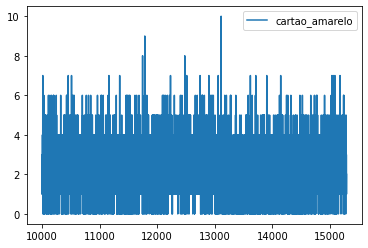

In [20]:
df_stats[10000:].plot(y='cartao_amarelo')

## 1.4 Goals 

In [21]:
df_goals = pd.read_csv(data_path + goals)
df_goals.head()

,partida_id,rodada,clube,atleta,minuto
0,4607,1,Fluminense,Rafael Sóbis,31
1,4607,1,Fluminense,Fred,45
2,4607,1,Fluminense,Nirley da Silva Fonseca,59
3,4608,1,Internacional,Charles Aránguiz,6
4,4610,1,Athletico-PR,Dráusio Luis Salla Gil,16


In [22]:
df_goals['gol'] = 1

In [23]:
df_goals.head()

,partida_id,rodada,clube,atleta,minuto,gol
0,4607,1,Fluminense,Rafael Sóbis,31,1
1,4607,1,Fluminense,Fred,45,1
2,4607,1,Fluminense,Nirley da Silva Fonseca,59,1
3,4608,1,Internacional,Charles Aránguiz,6,1
4,4610,1,Athletico-PR,Dráusio Luis Salla Gil,16,1


In [24]:
df_goals.shape

(7081, 6)

In [25]:
print('% of NaN')
df_goals.isna().sum()/df_goals.shape[0]

% of NaN


partida_id    0.0
rodada        0.0
clube         0.0
atleta        0.0
minuto        0.0
gol           0.0
dtype: float64

## 1.5 Legend

**Legenda - campeonato-brasileiro-full.csv**
- ID : ID da partida
- Rodada : Rodada que aconteceu a partida
- Data : Data que ocorreu a partida
- Horário :  Horário que ocorreu a partida
- Dia : Dia da semana que ocorreu a partida
- Mandante : Clube mandante                      
- Visitante : Clube Visitante
- formacao_mandante: Formação do mandante
- formacao_visitante: Formação do visitante
- tecnico_mandante: Técnico do mandante
- tecnico_visitante: Técnico do visitante
- Vencedor : Clube vencedor da partida. Quando tiver "-", é um empate
- Arena : Arena que ocorreu a partida                      
- Mandante Placar : Gols que o clube mandante fez na partida                      
- Visitante Placar : Gols que o clube visitante fez na partida                      
- Estado Mandante : Estado do clube mandatorio                      
- Estado Visitante : Estado do clube visitante                      
- Estado Vencedor : Estado do clube vencedor. Quando tiver "-", é um empate


**Legenda - campeonato-brasileiro-estatisticas-full.csv**
- partida_ID - ID da partida
- Rodada - Rodada da partida
- Clube - Nome do clube
- Chutes - Finalizações
- Chutes a gol - Finalizações na direção do gol
- Posse de bola - Percentual da posse de bola
- Passes - Quantidade de passes que o clube deu na partida
- precisao_passes - Percentual da precisão de passe
- Faltas - Quantidade de faltas cometidas na partida
- cartao_amarelo - Quantidade de cartões amarelos para o clube na partida
- cartao_vermelho - Quantidade de cartões vermelhos para o clube na partida
- Impedimentos - Quantidade de impedimentos para o clube na partida
- Escanteios - Quantidade de escanteios para o clube na partida


**Legenda - campeonato-brasileiro-gols.csv**
- partida_ID - ID da partida
- Rodada - Rodada da partida
- Clube - Nome do clube
- Atleta - Nome do atleta que fez o gol
- Minuto - Minuto na partida em que o gol foi marcado


**Legenda - campeonato-brasileiro-cartoes.csv**
- partida_ID - ID da partida
- Rodada - Rodada da partida
- Clube - Nome do clube
- Cartao - Cor do cartão aplicado
- Atleta - Nome do atleta punido pelo cartão
- num_camisa - Número da camisa do atleta
- Posicao - Posição na partida em que o atleta se encontra
- Minuto - Minuto na partida em que o cartão foi aplicado

## 1.6 Filling NA and and filtering data

### 1.6.1 Selecting recent games (5 years) 

In [26]:
df_full_recent = df_full[df_full['data'] > '2015-01-01']

In [27]:
# dataframe das partidas de 2018 em diante
df_full_recent.head()

,ID,rodada,data,hora,dia,mandante,visitante,formacao_mandante,formacao_visitante,tecnico_mandante,tecnico_visitante,vencedor,arena,mandante_placar,visitante_placar,mandante_estado,visitante_estado,estado_vencedor
4986,4987,1,2015-05-09,18:32,Sabado,Chapecoense,Coritiba,4-2-3-1,3-5-2,M. dos Santos Gonçalves,M. dos Santos Gonçalves,Chapecoense,arena conda,2,1,SC,PR,SC
4987,4988,1,2015-05-09,18:33,Sabado,Palmeiras,Atletico-MG,4-2-3-1,4-2-3-1,L. Culpi,L. Culpi,-,allianz parque,2,2,SP,MG,-
4988,4989,1,2015-05-09,21:00,Sabado,Fluminense,Joinville,4-3-1-2,4-4-1-1,H. Maria,H. Maria,Fluminense,maracana,1,0,RJ,SC,RJ
4989,4990,1,2015-05-10,11:00,Domingo,Gremio,Ponte Preta,4-2-3-1,4-1-2-1-2,A. Ferreira,A. Ferreira,-,arena do gremio,3,3,RS,SP,-
4990,4991,1,2015-05-10,16:00,Domingo,Athletico-PR,Internacional,4-2-3-1,4-2-3-1,D. Aguirre Camblor,D. Aguirre Camblor,Athletico-PR,estadio joaquim americo guimaraes,3,0,PR,RS,PR


In [28]:
columns = df_full_recent.columns.to_list()

### 1.6.2 Choosing some initial features to test 

In [29]:
columns = ['ID',
           'rodada',
           'data',
           'hora',
           'dia',
           'mandante',
           'visitante',
           'formacao_mandante',
           'formacao_visitante',
           'vencedor',
           'arena',
           'mandante_estado',
           'visitante_estado']

df_full_recent = df_full_recent[columns]

In [30]:
df_full_recent.head()

,ID,rodada,data,hora,dia,mandante,visitante,formacao_mandante,formacao_visitante,vencedor,arena,mandante_estado,visitante_estado
4986,4987,1,2015-05-09,18:32,Sabado,Chapecoense,Coritiba,4-2-3-1,3-5-2,Chapecoense,arena conda,SC,PR
4987,4988,1,2015-05-09,18:33,Sabado,Palmeiras,Atletico-MG,4-2-3-1,4-2-3-1,-,allianz parque,SP,MG
4988,4989,1,2015-05-09,21:00,Sabado,Fluminense,Joinville,4-3-1-2,4-4-1-1,Fluminense,maracana,RJ,SC
4989,4990,1,2015-05-10,11:00,Domingo,Gremio,Ponte Preta,4-2-3-1,4-1-2-1-2,-,arena do gremio,RS,SP
4990,4991,1,2015-05-10,16:00,Domingo,Athletico-PR,Internacional,4-2-3-1,4-2-3-1,Athletico-PR,estadio joaquim americo guimaraes,PR,RS


### 1.6.3 Selecting just recent stats (5 years) 

In [31]:
df_stats_recent = df_stats[df_stats['partida_id'] > 4987]

In [32]:
aux_val = []
for value in df_stats_recent['posse_de_bola'].values:
    if value != 'None':
        aux_val.append(np.float32(value[0:2]))
    else:
        aux_val.append(np.nan)

In [33]:
df_stats_recent.loc[:,'posse_de_bola'] = aux_val

/tmp/ipykernel_35371/1222983903.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stats_recent.loc[:,'posse_de_bola'] = aux_val


In [34]:
aux_val = []
for value in df_stats_recent['precisao_passes'].values:
    if value != 'None':
        aux_val.append(np.float32(value[0:2]))
    else:
        aux_val.append(np.nan)

In [35]:
df_stats_recent.loc[:, 'precisao_passes'] = aux_val

/tmp/ipykernel_35371/2135160869.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stats_recent.loc[:, 'precisao_passes'] = aux_val


In [36]:
df_stats_clube = df_stats_recent.groupby('clube').mean()
df_stats_clube = df_stats_clube.drop(['partida_id', 'rodada'], axis = 1)
df_stats_clube.head()

,chutes,chutes_no_alvo,posse_de_bola,passes,precisao_passes,faltas,cartao_amarelo,cartao_vermelho,impedimentos,escanteios
clube,,,,,,,,,,
America-MG,12.324561,2.561404,46.587719,397.912281,78.078947,14.763158,1.859649,0.105263,1.587719,4.657895
Athletico-PR,11.639098,3.026316,51.861789,414.973684,82.803030,14.030075,1.988722,0.086466,1.522556,4.609023
Atletico-GO,11.789474,3.561404,46.508772,385.026316,79.000000,15.912281,2.210526,0.087719,1.508772,5.315789
Atletico-MG,14.162264,3.471698,55.400000,475.166038,83.162162,14.592453,2.037736,0.090566,1.883019,5.947170
Avai,11.473684,1.938596,43.196429,351.438596,77.388889,14.815789,2.412281,0.157895,1.482456,4.850877


In [37]:
for column in df_stats_clube.columns.tolist():
    df_full_recent['mandante_' + column] = df_full_recent['mandante'].map(df_stats_clube[column])
    df_full_recent['visitante_' + column] = df_full_recent['visitante'].map(df_stats_clube[column])

### 1.6.4 Creating the target feature 

In [38]:
df_full_recent = df_full_recent.reset_index()

In [39]:
# 1 - mandante
# 2 - visitante
# 0 - empate

for i in range(0, len(df_full_recent)):
    if df_full_recent.loc[i, 'vencedor'] == df_full_recent.loc[i, 'mandante']:
        df_full_recent.loc[i, 'resultado'] = 1
    elif df_full_recent.loc[i, 'vencedor'] == df_full_recent.loc[i, 'visitante']:
        df_full_recent.loc[i, 'resultado'] = 2
    else:
        df_full_recent.loc[i, 'resultado'] = 0    

In [40]:
df_full_recent.head()

,index,ID,rodada,data,hora,dia,mandante,visitante,formacao_mandante,formacao_visitante,...,visitante_faltas,mandante_cartao_amarelo,visitante_cartao_amarelo,mandante_cartao_vermelho,visitante_cartao_vermelho,mandante_impedimentos,visitante_impedimentos,mandante_escanteios,visitante_escanteios,resultado
0,4986,4987,1,2015-05-09,18:32,Sabado,Chapecoense,Coritiba,4-2-3-1,3-5-2,...,16.576159,2.141593,2.589404,0.088496,0.145695,1.336283,1.867550,4.911504,4.549669,1.0
1,4987,4988,1,2015-05-09,18:33,Sabado,Palmeiras,Atletico-MG,4-2-3-1,4-2-3-1,...,14.592453,2.338346,2.037736,0.116541,0.090566,1.860902,1.883019,5.526316,5.947170,0.0
2,4988,4989,1,2015-05-09,21:00,Sabado,Fluminense,Joinville,4-3-1-2,4-4-1-1,...,16.578947,2.293233,2.473684,0.131579,0.210526,1.586466,1.736842,4.766917,5.289474,1.0
3,4989,4990,1,2015-05-10,11:00,Domingo,Gremio,Ponte Preta,4-2-3-1,4-1-2-1-2,...,16.798246,2.187970,2.491228,0.101504,0.149123,1.503759,1.754386,5.402256,5.166667,0.0
4,4990,4991,1,2015-05-10,16:00,Domingo,Athletico-PR,Internacional,4-2-3-1,4-2-3-1,...,16.131579,1.988722,2.557018,0.086466,0.175439,1.522556,1.614035,4.609023,5.618421,1.0


In [41]:
df_full_recent.dtypes

index                                 int64
ID                                    int64
rodada                                int64
data                         datetime64[ns]
hora                                 object
dia                                  object
mandante                             object
visitante                            object
formacao_mandante                    object
formacao_visitante                   object
vencedor                             object
arena                                object
mandante_estado                      object
visitante_estado                     object
mandante_chutes                     float64
visitante_chutes                    float64
mandante_chutes_no_alvo             float64
visitante_chutes_no_alvo            float64
mandante_posse_de_bola              float64
visitante_posse_de_bola             float64
mandante_passes                     float64
visitante_passes                    float64
mandante_precisao_passes        

# 2. Exploratory Data Analysy

In [42]:
df2 = df_full_recent.copy()

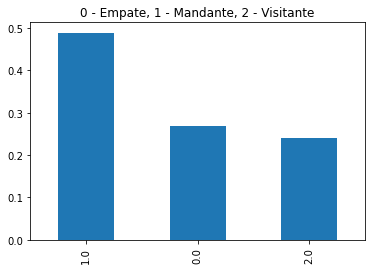

In [43]:
df2.resultado.value_counts(normalize=True).plot(kind='bar');
plt.title('0 - Empate, 1 - Mandante, 2 - Visitante');

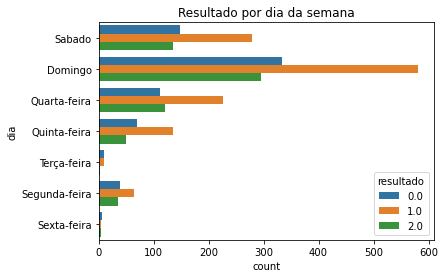

In [44]:
sns.countplot(y=df2.dia, hue=df2.resultado);
plt.title('Resultado por dia da semana');

# 3. Feature Engineering 

In [45]:
df3 = df2.copy()

In [46]:
to_drop = ['index', 'vencedor', 'ID']
df3 = df3.drop(to_drop, axis = 1)

In [47]:
df3.head()

,rodada,data,hora,dia,mandante,visitante,formacao_mandante,formacao_visitante,arena,mandante_estado,...,visitante_faltas,mandante_cartao_amarelo,visitante_cartao_amarelo,mandante_cartao_vermelho,visitante_cartao_vermelho,mandante_impedimentos,visitante_impedimentos,mandante_escanteios,visitante_escanteios,resultado
0,1,2015-05-09,18:32,Sabado,Chapecoense,Coritiba,4-2-3-1,3-5-2,arena conda,SC,...,16.576159,2.141593,2.589404,0.088496,0.145695,1.336283,1.867550,4.911504,4.549669,1.0
1,1,2015-05-09,18:33,Sabado,Palmeiras,Atletico-MG,4-2-3-1,4-2-3-1,allianz parque,SP,...,14.592453,2.338346,2.037736,0.116541,0.090566,1.860902,1.883019,5.526316,5.947170,0.0
2,1,2015-05-09,21:00,Sabado,Fluminense,Joinville,4-3-1-2,4-4-1-1,maracana,RJ,...,16.578947,2.293233,2.473684,0.131579,0.210526,1.586466,1.736842,4.766917,5.289474,1.0
3,1,2015-05-10,11:00,Domingo,Gremio,Ponte Preta,4-2-3-1,4-1-2-1-2,arena do gremio,RS,...,16.798246,2.187970,2.491228,0.101504,0.149123,1.503759,1.754386,5.402256,5.166667,0.0
4,1,2015-05-10,16:00,Domingo,Athletico-PR,Internacional,4-2-3-1,4-2-3-1,estadio joaquim americo guimaraes,PR,...,16.131579,1.988722,2.557018,0.086466,0.175439,1.522556,1.614035,4.609023,5.618421,1.0


In [48]:
df3.dtypes

rodada                                int64
data                         datetime64[ns]
hora                                 object
dia                                  object
mandante                             object
visitante                            object
formacao_mandante                    object
formacao_visitante                   object
arena                                object
mandante_estado                      object
visitante_estado                     object
mandante_chutes                     float64
visitante_chutes                    float64
mandante_chutes_no_alvo             float64
visitante_chutes_no_alvo            float64
mandante_posse_de_bola              float64
visitante_posse_de_bola             float64
mandante_passes                     float64
visitante_passes                    float64
mandante_precisao_passes            float64
visitante_precisao_passes           float64
mandante_faltas                     float64
visitante_faltas                

In [49]:
df3.loc[:,'hora_decimal'] = pd.to_datetime(df3.hora).dt.hour + pd.to_datetime(df3.hora).dt.minute / 60

In [50]:
df3['hora_sin_'] = df3['hora_decimal'].apply(lambda x: np.sin(x * (2 * np.pi/24)))

In [51]:
df3 = df3.drop(['hora', 'hora_decimal'], axis = 1)

In [52]:
df3.insert(2, 'hora_sin', df3.hora_sin_)

In [53]:
df3 = df3.drop('hora_sin_', axis = 1)

In [54]:
df3.head()

,rodada,data,hora_sin,dia,mandante,visitante,formacao_mandante,formacao_visitante,arena,mandante_estado,...,visitante_faltas,mandante_cartao_amarelo,visitante_cartao_amarelo,mandante_cartao_vermelho,visitante_cartao_vermelho,mandante_impedimentos,visitante_impedimentos,mandante_escanteios,visitante_escanteios,resultado
0,1,2015-05-09,-0.990268,Sabado,Chapecoense,Coritiba,4-2-3-1,3-5-2,arena conda,SC,...,16.576159,2.141593,2.589404,0.088496,0.145695,1.336283,1.867550,4.911504,4.549669,1.0
1,1,2015-05-09,-0.989651,Sabado,Palmeiras,Atletico-MG,4-2-3-1,4-2-3-1,allianz parque,SP,...,14.592453,2.338346,2.037736,0.116541,0.090566,1.860902,1.883019,5.526316,5.947170,0.0
2,1,2015-05-09,-0.707107,Sabado,Fluminense,Joinville,4-3-1-2,4-4-1-1,maracana,RJ,...,16.578947,2.293233,2.473684,0.131579,0.210526,1.586466,1.736842,4.766917,5.289474,1.0
3,1,2015-05-10,0.258819,Domingo,Gremio,Ponte Preta,4-2-3-1,4-1-2-1-2,arena do gremio,RS,...,16.798246,2.187970,2.491228,0.101504,0.149123,1.503759,1.754386,5.402256,5.166667,0.0
4,1,2015-05-10,-0.866025,Domingo,Athletico-PR,Internacional,4-2-3-1,4-2-3-1,estadio joaquim americo guimaraes,PR,...,16.131579,1.988722,2.557018,0.086466,0.175439,1.522556,1.614035,4.609023,5.618421,1.0


In [55]:
df3.dtypes

rodada                                int64
data                         datetime64[ns]
hora_sin                            float64
dia                                  object
mandante                             object
visitante                            object
formacao_mandante                    object
formacao_visitante                   object
arena                                object
mandante_estado                      object
visitante_estado                     object
mandante_chutes                     float64
visitante_chutes                    float64
mandante_chutes_no_alvo             float64
visitante_chutes_no_alvo            float64
mandante_posse_de_bola              float64
visitante_posse_de_bola             float64
mandante_passes                     float64
visitante_passes                    float64
mandante_precisao_passes            float64
visitante_precisao_passes           float64
mandante_faltas                     float64
visitante_faltas                

## 3.1 Features creation 

In [56]:
df3['ano'] = df3.data.dt.year
df3['dia_do_mes'] = df3.data.dt.day
df3['mes'] = df3.data.dt.month
df3['semana_do_ano'] = df3.data.dt.weekofyear

df3.head()

/tmp/ipykernel_35371/3886982136.py:4: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df3['semana_do_ano'] = df3.data.dt.weekofyear


,rodada,data,hora_sin,dia,mandante,visitante,formacao_mandante,formacao_visitante,arena,mandante_estado,...,visitante_cartao_vermelho,mandante_impedimentos,visitante_impedimentos,mandante_escanteios,visitante_escanteios,resultado,ano,dia_do_mes,mes,semana_do_ano
0,1,2015-05-09,-0.990268,Sabado,Chapecoense,Coritiba,4-2-3-1,3-5-2,arena conda,SC,...,0.145695,1.336283,1.867550,4.911504,4.549669,1.0,2015,9,5,19
1,1,2015-05-09,-0.989651,Sabado,Palmeiras,Atletico-MG,4-2-3-1,4-2-3-1,allianz parque,SP,...,0.090566,1.860902,1.883019,5.526316,5.947170,0.0,2015,9,5,19
2,1,2015-05-09,-0.707107,Sabado,Fluminense,Joinville,4-3-1-2,4-4-1-1,maracana,RJ,...,0.210526,1.586466,1.736842,4.766917,5.289474,1.0,2015,9,5,19
3,1,2015-05-10,0.258819,Domingo,Gremio,Ponte Preta,4-2-3-1,4-1-2-1-2,arena do gremio,RS,...,0.149123,1.503759,1.754386,5.402256,5.166667,0.0,2015,10,5,19
4,1,2015-05-10,-0.866025,Domingo,Athletico-PR,Internacional,4-2-3-1,4-2-3-1,estadio joaquim americo guimaraes,PR,...,0.175439,1.522556,1.614035,4.609023,5.618421,1.0,2015,10,5,19


## 3.1 Data transformation 

In [57]:
# month
df3['mes_sin'] = df3['mes'].apply(lambda x: np.sin(x * (2 * np.pi/12)))
df3['mes_cos'] = df3['mes'].apply(lambda x: np.cos(x * (2 * np.pi/12)))
# day
df3['dia_do_mes_sin'] = df3['dia_do_mes'].apply(lambda x: np.sin(x * (2 * np.pi/30)))
df3['dia_do_mes_cos'] = df3['dia_do_mes'].apply(lambda x: np.cos(x * (2 * np.pi/30)))
# week of year
df3['semana_do_ano_sin'] = df3['semana_do_ano'].apply(lambda x: np.sin(x * (2 * np.pi/52)))
df3['semana_do_ano_cos'] = df3['semana_do_ano'].apply(lambda x: np.cos(x * (2 * np.pi/52)))

In [58]:
df3.head()

,rodada,data,hora_sin,dia,mandante,visitante,formacao_mandante,formacao_visitante,arena,mandante_estado,...,ano,dia_do_mes,mes,semana_do_ano,mes_sin,mes_cos,dia_do_mes_sin,dia_do_mes_cos,semana_do_ano_sin,semana_do_ano_cos
0,1,2015-05-09,-0.990268,Sabado,Chapecoense,Coritiba,4-2-3-1,3-5-2,arena conda,SC,...,2015,9,5,19,0.5,-0.866025,0.951057,-0.309017,0.748511,-0.663123
1,1,2015-05-09,-0.989651,Sabado,Palmeiras,Atletico-MG,4-2-3-1,4-2-3-1,allianz parque,SP,...,2015,9,5,19,0.5,-0.866025,0.951057,-0.309017,0.748511,-0.663123
2,1,2015-05-09,-0.707107,Sabado,Fluminense,Joinville,4-3-1-2,4-4-1-1,maracana,RJ,...,2015,9,5,19,0.5,-0.866025,0.951057,-0.309017,0.748511,-0.663123
3,1,2015-05-10,0.258819,Domingo,Gremio,Ponte Preta,4-2-3-1,4-1-2-1-2,arena do gremio,RS,...,2015,10,5,19,0.5,-0.866025,0.866025,-0.500000,0.748511,-0.663123
4,1,2015-05-10,-0.866025,Domingo,Athletico-PR,Internacional,4-2-3-1,4-2-3-1,estadio joaquim americo guimaraes,PR,...,2015,10,5,19,0.5,-0.866025,0.866025,-0.500000,0.748511,-0.663123


In [59]:
# rodadas
df3['rodadas_sin'] = df3['rodada'].apply(lambda x: np.sin(x * (2 * np.pi/38)))
df3['rodadas_cos'] = df3['rodada'].apply(lambda x: np.cos(x * (2 * np.pi/38)))

In [60]:
df3.columns.tolist()

['rodada',
 'data',
 'hora_sin',
 'dia',
 'mandante',
 'visitante',
 'formacao_mandante',
 'formacao_visitante',
 'arena',
 'mandante_estado',
 'visitante_estado',
 'mandante_chutes',
 'visitante_chutes',
 'mandante_chutes_no_alvo',
 'visitante_chutes_no_alvo',
 'mandante_posse_de_bola',
 'visitante_posse_de_bola',
 'mandante_passes',
 'visitante_passes',
 'mandante_precisao_passes',
 'visitante_precisao_passes',
 'mandante_faltas',
 'visitante_faltas',
 'mandante_cartao_amarelo',
 'visitante_cartao_amarelo',
 'mandante_cartao_vermelho',
 'visitante_cartao_vermelho',
 'mandante_impedimentos',
 'visitante_impedimentos',
 'mandante_escanteios',
 'visitante_escanteios',
 'resultado',
 'ano',
 'dia_do_mes',
 'mes',
 'semana_do_ano',
 'mes_sin',
 'mes_cos',
 'dia_do_mes_sin',
 'dia_do_mes_cos',
 'semana_do_ano_sin',
 'semana_do_ano_cos',
 'rodadas_sin',
 'rodadas_cos']

In [61]:
to_drop = ['dia', 'mes', 'ano', 'data', 'rodada', 'dia_do_mes', 'semana_do_ano']
df3 = df3.drop(to_drop, axis=1)

In [62]:
df3.head()

,hora_sin,mandante,visitante,formacao_mandante,formacao_visitante,arena,mandante_estado,visitante_estado,mandante_chutes,visitante_chutes,...,visitante_escanteios,resultado,mes_sin,mes_cos,dia_do_mes_sin,dia_do_mes_cos,semana_do_ano_sin,semana_do_ano_cos,rodadas_sin,rodadas_cos
0,-0.990268,Chapecoense,Coritiba,4-2-3-1,3-5-2,arena conda,SC,PR,12.092920,11.437086,...,4.549669,1.0,0.5,-0.866025,0.951057,-0.309017,0.748511,-0.663123,0.164595,0.986361
1,-0.989651,Palmeiras,Atletico-MG,4-2-3-1,4-2-3-1,allianz parque,SP,MG,13.928571,14.162264,...,5.947170,0.0,0.5,-0.866025,0.951057,-0.309017,0.748511,-0.663123,0.164595,0.986361
2,-0.707107,Fluminense,Joinville,4-3-1-2,4-4-1-1,maracana,RJ,SC,12.342105,10.868421,...,5.289474,1.0,0.5,-0.866025,0.951057,-0.309017,0.748511,-0.663123,0.164595,0.986361
3,0.258819,Gremio,Ponte Preta,4-2-3-1,4-1-2-1-2,arena do gremio,RS,SP,13.187970,12.280702,...,5.166667,0.0,0.5,-0.866025,0.866025,-0.500000,0.748511,-0.663123,0.164595,0.986361
4,-0.866025,Athletico-PR,Internacional,4-2-3-1,4-2-3-1,estadio joaquim americo guimaraes,PR,RS,11.639098,12.447368,...,5.618421,1.0,0.5,-0.866025,0.866025,-0.500000,0.748511,-0.663123,0.164595,0.986361


In [63]:
df3.insert(len(df3.columns.tolist()), 'resultado_final', df3.resultado)

In [64]:
df3 = df3.drop('resultado', axis = 1)

In [65]:
df3['resultado_final'] = df3.resultado_final.astype(int)

In [66]:
df3.dtypes

hora_sin                     float64
mandante                      object
visitante                     object
formacao_mandante             object
formacao_visitante            object
arena                         object
mandante_estado               object
visitante_estado              object
mandante_chutes              float64
visitante_chutes             float64
mandante_chutes_no_alvo      float64
visitante_chutes_no_alvo     float64
mandante_posse_de_bola       float64
visitante_posse_de_bola      float64
mandante_passes              float64
visitante_passes             float64
mandante_precisao_passes     float64
visitante_precisao_passes    float64
mandante_faltas              float64
visitante_faltas             float64
mandante_cartao_amarelo      float64
visitante_cartao_amarelo     float64
mandante_cartao_vermelho     float64
visitante_cartao_vermelho    float64
mandante_impedimentos        float64
visitante_impedimentos       float64
mandante_escanteios          float64
v

In [132]:
categorical = ['mandante', 'visitante']
target = ['resultado_final']

df3_cat = df3[categorical]
df3_target = df3[target]

In [133]:
df3_cat_dummies = pd.get_dummies(df3_cat)

In [134]:
df3_cat_dummies

,mandante_America-MG,mandante_Athletico-PR,mandante_Atletico-GO,mandante_Atletico-MG,mandante_Avai,mandante_Bahia,mandante_Botafogo-RJ,mandante_Bragantino,mandante_CSA,mandante_Ceara,...,visitante_Juventude,visitante_Palmeiras,visitante_Parana,visitante_Ponte Preta,visitante_Santa Cruz,visitante_Santos,visitante_Sao Paulo,visitante_Sport,visitante_Vasco,visitante_Vitoria
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2654,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2655,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2656,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2657,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [135]:
categorical.append(target[0])

In [137]:
to_drop = ['mandante',
           'visitante',
           'formacao_mandante',
           'formacao_visitante',
           'arena',
           'mandante_estado',
           'visitante_estado',
           'resultado_final']

In [138]:
df3_numeric = df3.drop(to_drop, axis=1)

In [139]:
columns = df3_numeric.columns.tolist()

In [140]:
ss = StandardScaler()
df3_numeric_scaled = pd.DataFrame(ss.fit_transform(df3_numeric), columns=columns)

In [141]:
df3_numeric_scaled.head()

,hora_sin,mandante_chutes,visitante_chutes,mandante_chutes_no_alvo,visitante_chutes_no_alvo,mandante_posse_de_bola,visitante_posse_de_bola,mandante_passes,visitante_passes,mandante_precisao_passes,...,mandante_escanteios,visitante_escanteios,mes_sin,mes_cos,dia_do_mes_sin,dia_do_mes_cos,semana_do_ano_sin,semana_do_ano_cos,rodadas_sin,rodadas_cos
0,-0.667244,-0.503856,-1.163103,-0.693566,-1.324889,-1.201166,-0.672772,-1.375292,-0.843699,-1.878253,...,-0.448971,-1.145905,1.758753,-1.07702,1.320394,-0.395739,1.986769,-0.697683,0.232728,1.39572
1,-0.665172,1.342169,1.578629,0.577490,0.552568,0.450870,1.343022,0.000432,1.294262,-0.048304,...,0.735696,1.548019,1.758753,-1.07702,1.320394,-0.395739,1.986769,-0.697683,0.232728,1.39572
2,0.283858,-0.253263,-1.735223,0.256223,-3.557089,0.247318,-1.198691,0.276276,-1.563531,0.578335,...,-0.727572,0.280196,1.758753,-1.07702,1.320394,-0.395739,1.986769,-0.697683,0.232728,1.39572
3,3.528278,0.597382,-0.314363,0.398499,-1.982933,1.045505,-0.921516,1.723539,-0.844236,1.390821,...,0.496647,0.043464,1.758753,-1.07702,1.198025,-0.661765,1.986769,-0.697683,0.232728,1.39572
4,-0.249929,-0.960244,-0.146684,0.008389,-0.066103,0.461719,0.306127,-0.077024,0.226917,0.942457,...,-1.031816,0.914299,1.758753,-1.07702,1.198025,-0.661765,1.986769,-0.697683,0.232728,1.39572


In [142]:
df3_final = pd.concat([df3_cat_dummies, df3_numeric_scaled, df3_target], axis =1)

In [143]:
df3_final

,mandante_America-MG,mandante_Athletico-PR,mandante_Atletico-GO,mandante_Atletico-MG,mandante_Avai,mandante_Bahia,mandante_Botafogo-RJ,mandante_Bragantino,mandante_CSA,mandante_Ceara,...,visitante_escanteios,mes_sin,mes_cos,dia_do_mes_sin,dia_do_mes_cos,semana_do_ano_sin,semana_do_ano_cos,rodadas_sin,rodadas_cos,resultado_final
0,0,0,0,0,0,0,0,0,0,0,...,-1.145905,1.758753,-1.077020,1.320394,-0.395739,1.986769,-0.697683,2.327281e-01,1.395720,1
1,0,0,0,0,0,0,0,0,0,0,...,1.548019,1.758753,-1.077020,1.320394,-0.395739,1.986769,-0.697683,2.327281e-01,1.395720,0
2,0,0,0,0,0,0,0,0,0,0,...,0.280196,1.758753,-1.077020,1.320394,-0.395739,1.986769,-0.697683,2.327281e-01,1.395720,1
3,0,0,0,0,0,0,0,0,0,0,...,0.043464,1.758753,-1.077020,1.198025,-0.661765,1.986769,-0.697683,2.327281e-01,1.395720,0
4,0,1,0,0,0,0,0,0,0,0,...,0.914299,1.758753,-1.077020,1.198025,-0.661765,1.986769,-0.697683,2.327281e-01,1.395720,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2654,0,0,0,0,0,0,0,1,0,0,...,0.914299,0.817046,1.505231,0.797610,-1.092203,0.076954,1.624427,-2.858633e-16,1.415012,1
2655,0,0,0,0,0,0,0,0,0,0,...,-1.031491,0.817046,1.505231,0.797610,-1.092203,0.076954,1.624427,-2.858633e-16,1.415012,0
2656,0,0,0,0,0,0,0,0,0,0,...,0.193233,0.817046,1.505231,0.797610,-1.092203,0.076954,1.624427,-2.858633e-16,1.415012,1
2657,0,0,0,0,0,0,0,0,0,0,...,1.548019,0.817046,1.505231,0.797610,-1.092203,0.076954,1.624427,-2.858633e-16,1.415012,1


# 4.0 Feature selection and scaling 

In [144]:
df4 = df3_final.copy()

In [145]:
df4 = df4.dropna()

In [146]:
df4.head()

,mandante_America-MG,mandante_Athletico-PR,mandante_Atletico-GO,mandante_Atletico-MG,mandante_Avai,mandante_Bahia,mandante_Botafogo-RJ,mandante_Bragantino,mandante_CSA,mandante_Ceara,...,visitante_escanteios,mes_sin,mes_cos,dia_do_mes_sin,dia_do_mes_cos,semana_do_ano_sin,semana_do_ano_cos,rodadas_sin,rodadas_cos,resultado_final
0,0,0,0,0,0,0,0,0,0,0,...,-1.145905,1.758753,-1.07702,1.320394,-0.395739,1.986769,-0.697683,0.232728,1.39572,1
1,0,0,0,0,0,0,0,0,0,0,...,1.548019,1.758753,-1.07702,1.320394,-0.395739,1.986769,-0.697683,0.232728,1.39572,0
4,0,1,0,0,0,0,0,0,0,0,...,0.914299,1.758753,-1.07702,1.198025,-0.661765,1.986769,-0.697683,0.232728,1.39572,1
5,0,0,0,0,0,0,0,0,0,0,...,1.968721,1.758753,-1.07702,1.198025,-0.661765,1.986769,-0.697683,0.232728,1.39572,1
6,0,0,0,0,0,0,0,0,0,0,...,0.193233,1.758753,-1.07702,1.198025,-0.661765,1.986769,-0.697683,0.232728,1.39572,2


In [184]:
X = df4.drop(['resultado_final'], axis=1)
y = df4.resultado_final

In [185]:
X_train, X_test, y_train, y_test = train_test_split(X, y,shuffle=True)

In [186]:
undersampling = RandomUnderSampler(random_state=32)

In [187]:
X_train, y_train = undersampling.fit_resample(X_train, y_train)

<AxesSubplot:xlabel='resultado_final', ylabel='count'>

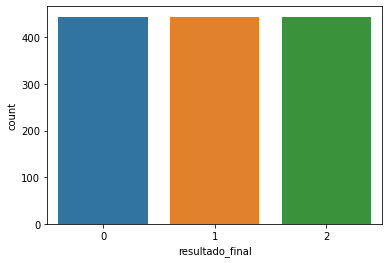

In [188]:
sns.countplot(y_train)

# 5.0 Machine Learning Models 

## 5.1 Logistic Regression 

In [189]:
clf_lg = LogisticRegression().fit(X_train, y_train)
y_hat_lg = clf_lg.predict(X_test)

In [190]:
accuracy_score(y_test, y_hat_lg)

0.4152823920265781

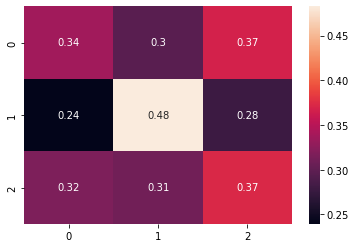

In [191]:
sns.heatmap(confusion_matrix(y_test, y_hat_lg, normalize='true'), annot=True);

In [192]:
print(classification_report(y_test, y_hat_lg))

              precision    recall  f1-score   support

           0       0.33      0.34      0.33       169
           1       0.59      0.48      0.53       288
           2       0.28      0.37      0.32       145

    accuracy                           0.42       602
   macro avg       0.40      0.40      0.39       602
weighted avg       0.44      0.42      0.42       602



## 5.2 XGBoost 

In [193]:
clf_xgb = xgb.XGBRFClassifier(n_estimators = 1000).fit(X_train, y_train)
yhat_xgb = clf_xgb.predict(X_test)

[11:37:11] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [194]:
accuracy_score(y_test, yhat_xgb)

0.4219269102990033

<AxesSubplot:>

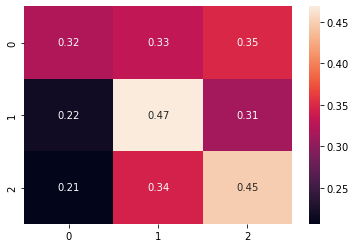

In [195]:
sns.heatmap(confusion_matrix(y_test, yhat_xgb, normalize='true'), annot=True, )

In [196]:
print(classification_report(y_test, yhat_xgb))

              precision    recall  f1-score   support

           0       0.37      0.32      0.34       169
           1       0.56      0.47      0.51       288
           2       0.30      0.45      0.36       145

    accuracy                           0.42       602
   macro avg       0.41      0.41      0.40       602
weighted avg       0.44      0.42      0.43       602



## 5.3 Random Forests

In [197]:
clf_rf = RandomForestClassifier(n_estimators = 2000, n_jobs = -1, random_state = 42).fit(X_train, y_train)
yhat_rf = clf_rf.predict(X_test)

In [198]:
accuracy_score(y_test, yhat_rf)

0.42358803986710963

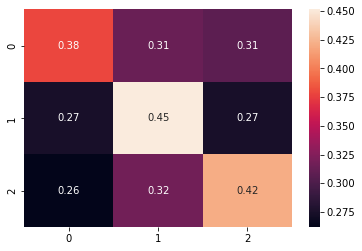

In [199]:
sns.heatmap(confusion_matrix(y_test, yhat_rf, normalize='true'), annot=True, );

In [200]:
print(classification_report(y_test, yhat_rf))

              precision    recall  f1-score   support

           0       0.35      0.38      0.37       169
           1       0.57      0.45      0.50       288
           2       0.32      0.42      0.36       145

    accuracy                           0.42       602
   macro avg       0.41      0.42      0.41       602
weighted avg       0.45      0.42      0.43       602



## 5.4 SVM 

In [201]:
clf_svc = svm.SVC().fit(X_train, y_train)
y_hat_svc = clf_svc.predict(X_test)

In [202]:
accuracy_score(y_test, y_hat_svc)

0.4219269102990033

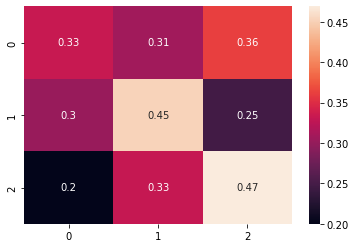

In [203]:
sns.heatmap(confusion_matrix(y_test, y_hat_svc, normalize='true'), annot=True);

In [204]:
print(classification_report(y_test, y_hat_svc))

              precision    recall  f1-score   support

           0       0.33      0.33      0.33       169
           1       0.57      0.45      0.50       288
           2       0.34      0.47      0.39       145

    accuracy                           0.42       602
   macro avg       0.41      0.42      0.41       602
weighted avg       0.44      0.42      0.43       602



## 5.5 Naive Bayes 

In [205]:
clf_gb = GaussianNB().fit(X_train, y_train)
y_hat_gnb = clf_gb.predict(X_test)

In [206]:
accuracy_score(y_test, y_hat_gnb)

0.3754152823920266

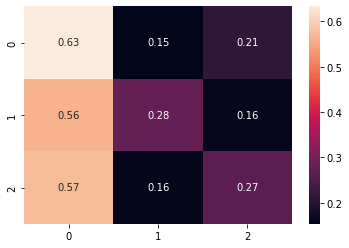

In [207]:
sns.heatmap(confusion_matrix(y_test, y_hat_gnb, normalize='true'), annot=True, );

In [208]:
print(classification_report(y_test, y_hat_gnb))

              precision    recall  f1-score   support

           0       0.30      0.63      0.41       169
           1       0.62      0.28      0.38       288
           2       0.32      0.27      0.29       145

    accuracy                           0.38       602
   macro avg       0.42      0.39      0.36       602
weighted avg       0.46      0.38      0.37       602



## 5.6 SGD Classifier 

In [209]:
clf_sgd = SGDClassifier().fit(X_train, y_train)
y_hat_sgd = clf_sgd.predict(X_test)

In [210]:
accuracy_score(y_test, y_hat_sgd)

0.36046511627906974

<AxesSubplot:>

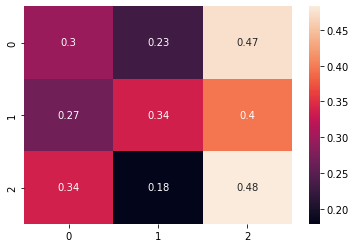

In [211]:
sns.heatmap(confusion_matrix(y_test, y_hat_sgd, normalize='true'), annot=True, )

In [212]:
print(classification_report(y_test, y_hat_sgd))

              precision    recall  f1-score   support

           0       0.28      0.30      0.29       169
           1       0.60      0.34      0.43       288
           2       0.27      0.48      0.34       145

    accuracy                           0.36       602
   macro avg       0.38      0.37      0.35       602
weighted avg       0.43      0.36      0.37       602



## 5.7 Decision Tree

In [213]:
clf_dt = tree.DecisionTreeClassifier().fit(X_train, y_train)
y_hat_dt = clf_dt.predict(X_test)

In [214]:
accuracy_score(y_test, y_hat_dt)

0.4152823920265781

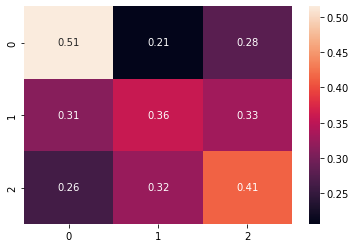

In [215]:
sns.heatmap(confusion_matrix(y_test, y_hat_dt, normalize='true'), annot=True, );

In [216]:
print(classification_report(y_test, y_hat_dt))

              precision    recall  f1-score   support

           0       0.40      0.51      0.45       169
           1       0.56      0.36      0.44       288
           2       0.30      0.41      0.35       145

    accuracy                           0.42       602
   macro avg       0.42      0.43      0.41       602
weighted avg       0.45      0.42      0.42       602



## 5.8 MLP

In [217]:
clf_mlp = MLPClassifier(max_iter=500).fit(X_train, y_train)
y_hat_mlp = clf_mlp.predict(X_test)

In [218]:
accuracy_score(y_test, y_hat_mlp)

0.39700996677740863

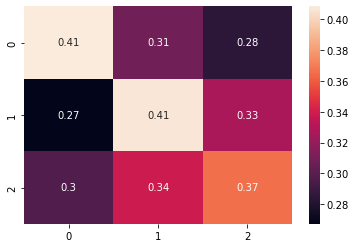

In [219]:
sns.heatmap(confusion_matrix(y_test, y_hat_mlp, normalize='true'), annot=True, );

In [220]:
print(classification_report(y_test, y_hat_mlp))

              precision    recall  f1-score   support

           0       0.37      0.41      0.39       169
           1       0.54      0.41      0.46       288
           2       0.27      0.37      0.31       145

    accuracy                           0.40       602
   macro avg       0.39      0.39      0.39       602
weighted avg       0.42      0.40      0.40       602



# 6.0 Ensemble 

In [221]:
import warnings
warnings.filterwarnings("ignore")

In [222]:
eclf = VotingClassifier(estimators=[('logistic', clf_lg), ('xgb', clf_xgb), ('random_forest', clf_rf), ('naive_bayes', clf_gb), ('decision_tree', clf_dt), ('mlp', clf_mlp)], voting='hard')

In [223]:
for clf, label in zip([clf_lg, clf_xgb, clf_rf, clf_gb, clf_dt], ['logistic', 'xgb', 'random_forest', 'naive_bayes', 'decision_tree', 'mlp' ]):
    scores = cross_val_score(clf, X, y, scoring='accuracy', cv=5)
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.47 (+/- 0.03) [logistic]
[11:37:32] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:37:41] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:37:50] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:37:58] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_m

In [224]:
eclf = VotingClassifier(estimators=[('decision_tree', clf_dt), ('sgd', clf_sgd), ('mlp', clf_mlp)], voting='hard', weights=[0.3, 0.3, 0.4]).fit(X_train, y_train)

In [225]:
y_hat_eclf = eclf.predict(X_test)

In [226]:
accuracy_score(y_test, y_hat_eclf)

0.4318936877076412

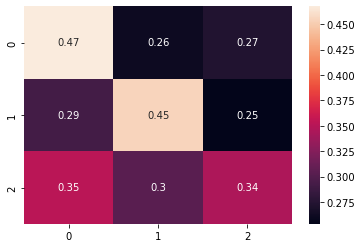

In [227]:
sns.heatmap(confusion_matrix(y_test, y_hat_eclf, normalize='true'), annot=True, );

In [228]:
print(classification_report(y_test, y_hat_eclf))

              precision    recall  f1-score   support

           0       0.37      0.47      0.41       169
           1       0.60      0.45      0.52       288
           2       0.30      0.34      0.32       145

    accuracy                           0.43       602
   macro avg       0.42      0.42      0.42       602
weighted avg       0.46      0.43      0.44       602

